# SongTron

In [3]:
"""
def binarize(image):
    #Binarizing image
    arr = image.flatten()
    mean = arr.mean()
    print("mean: {}".format(mean))

"""
import imageio
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [4]:
def kernel_horizontal(bin_im):
    horizontal = np.copy(bin_im)
    rows = horizontal.shape[1]
    size = rows//30
    structure = cv2.getStructuringElement(cv2.MORPH_RECT, (size, 1))
    print(structure)
    horizontal = cv2.erode(horizontal, structure)
    horizontal = cv2.dilate(horizontal, structure)
    return horizontal

def conv2d_image(f, w):
    N, M = f.shape[0:2]
    n, m = w.shape[0:2]
    w_flip = np.flip(np.flip(w, 0), 1)
    a = n//2  # floor of n/2
    b = m//2  # floor of m/2
    g = np.zeros(f.shape, dtype=np.float)
    for x in range(a, N-a):
        for y in range(b, M-b):
            region_f = f[x-a:x+(a+1), y-b:y+(b+1)]
            g[x][y] = np.sum(np.multiply(region_f.astype(np.float), w_flip.astype(np.float)))
    return g


def otsu_threshold(im):

    # Compute histogram and probabilities of each intensity level
    pixel_counts = [np.sum(im == i) for i in range(256)]
    n, m = im.shape[0:2]
    # Initialization
    s_max = (0,0)

    for threshold in range(256):

        # update
        w_0 = sum(pixel_counts[:threshold])
        w_1 = sum(pixel_counts[threshold:])

        mu_0 = sum([i * pixel_counts[i] for i in range(0,threshold)])\
                        / w_0 if w_0 > 0 else 0
        mu_1 = sum([i * pixel_counts[i] for i in range(threshold, 256)])\
                        / w_1 if w_1 > 0 else 0

        # calculate - inter class variance
        s = w_0 * w_1 * (mu_0 - mu_1) ** 2

        if s > s_max[1]:
            s_max = (threshold, s)
    return s_max[0]

def threshold(pic, threshold):
    return ((pic < threshold) * 255).astype('uint8')

### Image segmentation stuff

In [5]:
def distance(a, b):
    return np.abs(a-b)

def region_growing_average(img, img_t, tolerance, seed, region_n): 
    x = seed[0]; y = seed[1]
    img_t[x, y] = region_n
    avg = np.mean(img[np.where(img_t==region_n)])
    
    # check matrix border and conquering criterion for the 4-neigbourhood
    if (y+1 < img.shape[1] and img_t[x,y+1] == 0 and distance(avg, img[x, y+1]) <= tolerance):
        region_growing_average(img, img_t, tolerance, [x, y+1], region_n)
        
    if (y-1 >= 0 and img_t[x,y-1] == 0  and distance(avg, img[x, y-1]) <= tolerance):
        region_growing_average(img, img_t, tolerance, [x, y-1], region_n)
        
    if (x+1 < img.shape[0] and img_t[x+1,y] == 0  and distance(avg, img[x+1, y]) <= tolerance):
        region_growing_average(img, img_t, tolerance, [x+1, y], region_n)
        
    if (x-1 >= 0 and img_t[x-1,y] == 0  and distance(avg, img[x-1, y]) <= tolerance):
        region_growing_average(img, img_t, tolerance, [x-1, y], region_n)
        
def do_segmentation(image, thresh):
    segment_matrix = np.zeros(image.shape)
    region_counter = 1
    
    #Will check if region is above some treshold
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            pixel_val = image[x, y]
            if segment_matrix[x, y] == 0 and pixel_val >= thresh: #in case not assigned yet
                print("Pixel {} above threshold".format((x,y)))
                region_growing_average(image, segment_matrix, 10, (x, y), region_counter)
                region_counter += 1
                print("X: {} Y: {} Region: {}".format(x,y,region_counter))
    #print("Segmented regions: {}".format(region_counter))
    return segment_matrix

In [6]:
def get_bounding_rectangle(segment_matrix, segment_number):
    segment_indexes = np.where(segment_matrix == segment_number)
    max_x = segment_indexes[0].max()
    min_x = segment_indexes[0].min()
    max_y = segment_indexes[1].max()
    min_y = segment_indexes[1].min()
    return (min_x, max_x, min_y, max_y)

In [7]:
def main(filename):
    pic = imageio.imread(filename)
    gray = lambda rgb : np.dot(rgb[... , :3] , [0.21 , 0.72, 0.07])

    plt.figure(figsize=(12,12))
    plt.title("Original")
    plt.imshow(pic, cmap='gray')
    plt.axis('off')
    
    bin_img = threshold(gray(pic), otsu_threshold(pic))
    plt.figure(figsize=(12,12))
    plt.title("Binarized")
    plt.imshow(bin_img, cmap='gray')
    plt.axis('off')

    lines = kernel_horizontal(bin_img)
    plt.figure(figsize=(12,12))
    plt.title("Lines")
    plt.imshow(lines, cmap='gray')
    plt.axis('off')
    #Here it would be nice if we segmented the lines.
    """segmented_lines = do_segmentation(lines, otsu_threshold(pic))

    plt.figure(figsize=(20,20))
    plt.title("Segmented")
    plt.imshow(segmented_lines, cmap='magma')
    plt.axis('off')
    """
    bin_img[lines == 255] = 0 
    plt.figure(figsize=(12,12))
    plt.title("Lines removed")
    plt.imshow(bin_img, cmap='gray')
    plt.axis('off')
    """
    blurred = cv2.medianBlur(bin_img, 5)
    plt.figure(figsize=(12,12))
    plt.title("Blurred")
    plt.imshow(blurred, cmap='gray')
    plt.axis('off')
    """

    #Morphological closing.
    kernel = np.ones((4,1),np.uint8)
    closing = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, kernel)

    plt.figure(figsize=(12,12))
    plt.title("Morphological Close")
    plt.imshow(closing, cmap='gray')
    plt.axis('off')
    segmented_notes = do_segmentation(closing, otsu_threshold(pic))
    
    mask = np.zeros(segmented_notes.shape)
    mask[segmented_notes > 0] = 1
    
    plt.figure(figsize=(20,20))
    plt.title("Segmented")
    plt.imshow(segmented_notes, cmap='magma')
    plt.axis('off')

    plt.figure(figsize=(20,20))
    plt.title("Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    #Dilating image now...
    kernel_dilate = np.ones((3,3),np.uint8)
    dilated_mask = cv2.dilate(mask, kernel_dilate)
    
    plt.figure(figsize=(20,20))
    plt.title("Dilated mask")
    plt.imshow(dilated_mask, cmap='gray')
    plt.axis('off')
    
    for region in np.unique(segmented_notes):
        ranges = get_bounding_rectangle(segmented_notes, region)
        print("Reg. {} Ranges are {}".format(region, ranges))
        temp = np.copy(closing)
        img = temp[ranges[0]:ranges[1],ranges[2]:ranges[3]]
        plt.figure(figsize=(4,4))
        plt.title("Figure nº {}".format(region))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    
    plt.show()

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1]]
Pixel (4, 34) above threshold
X: 4 Y: 34 Region: 2
Pixel (10, 78) above threshold
X: 10 Y: 78 Region: 3
Pixel (10, 96) above threshold
X: 10 Y: 96 Region: 4
Pixel (20, 43) above threshold
X: 20 Y: 43 Region: 5
Pixel (27, 43) above threshold
X: 27 Y: 43 Region: 6
Pixel (55, 37) above threshold
X: 55 Y: 37 Region: 7
Pixel (60, 235) above threshold
X: 60 Y: 235 Region: 8
Pixel (60, 326) above threshold
X: 60 Y: 326 Region: 9
Pixel (60, 417) above threshold
X: 60 Y: 417 Region: 10
Pixel (74, 5) above threshold
X: 74 Y: 5 Region: 11
Pixel (76, 82) above threshold
X: 76 Y: 82 Region: 12
Pixel (76, 493) above threshold
X: 76 Y: 493 Region: 13
Pixel (76, 624) above threshold
X: 76 Y: 624 Region: 14
Pixel (76, 715) above threshold
X: 76 Y: 715 Region: 15
Pixel (76, 806) above threshold
X: 76 Y: 806 Region: 16
Pixel (76, 882) above threshold
X: 76 Y: 882 Region: 17
Pixel (76, 1179) above threshold
X: 76 Y: 1179

/home/hiram/Workspace/miniconda3/envs/imgproc/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reg. 18.0 Ranges are (76, 131, 1187, 1193)
Reg. 19.0 Ranges are (82, 139, 517, 534)
Reg. 20.0 Ranges are (91, 96, 1023, 1039)
Reg. 21.0 Ranges are (105, 161, 118, 146)


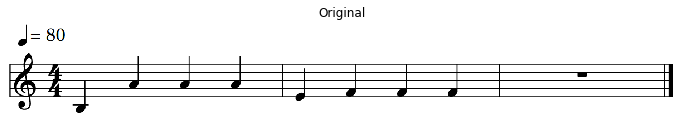

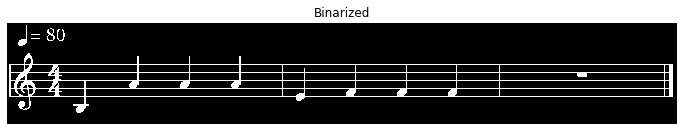

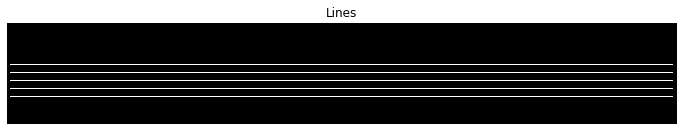

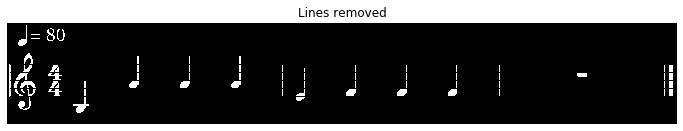

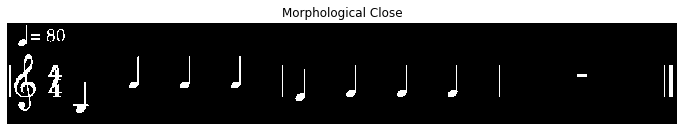

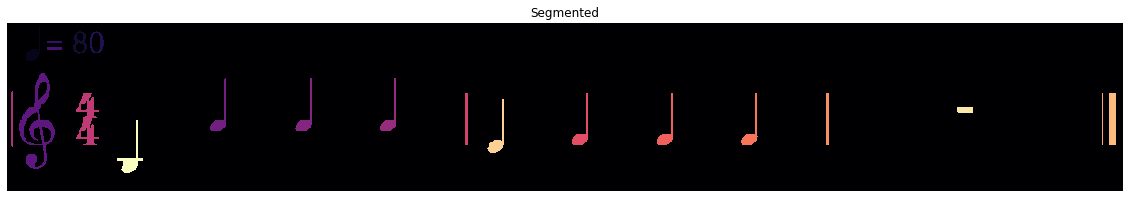

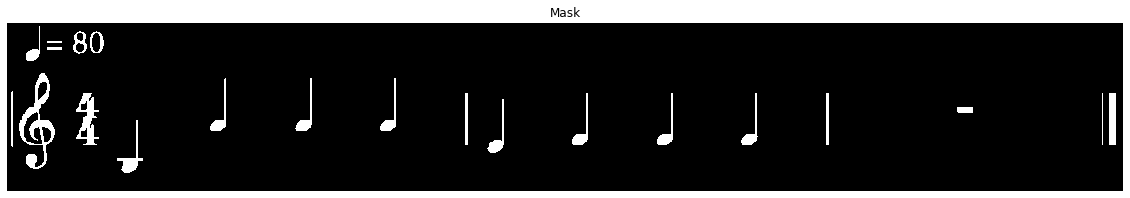

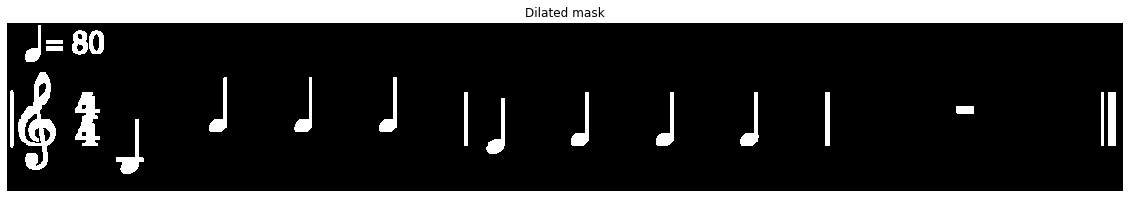

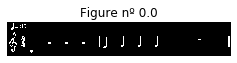

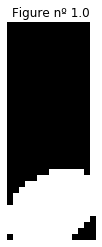

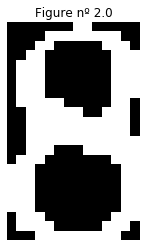

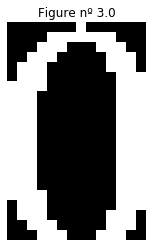

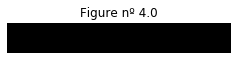

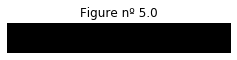

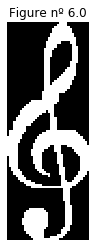

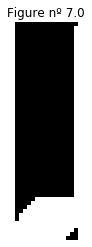

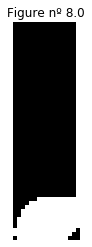

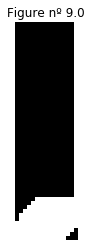

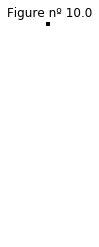

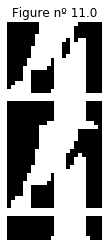

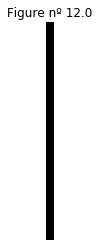

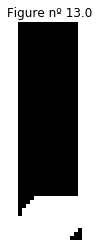

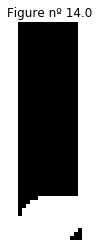

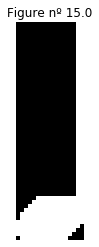

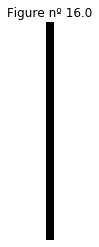

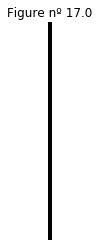

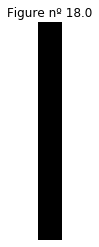

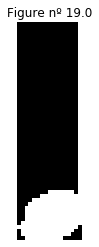

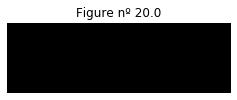

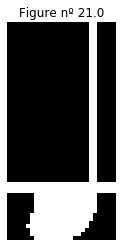

In [14]:
file1 = "../assets/songtron_test_0.png"
main(file1)    

In [ ]:
file2 = "../assets/danse_macabre_cut_0.png"
main(file2)

In [ ]:
file3 = "../assets/asa_branca.jpg"
main(file3)

# Just lines here lol

In [21]:
#so this function will only find lines' height
#image should suffer some dilation...
def find_lines_height(img, thresh):
    lines_found_heights = []
    x,y = img.shape
    search_y = y//2
    inside_line = False
    
    for temp_x in range(x):
        if img[temp_x, search_y] > thresh: #were are in a white pixel
            print("Pixel {} is above thresh.".format((temp_x, search_y)))
            if not inside_line:
                lines_found_heights.append(temp_x)
            inside_line = True
        else:
            inside_line = False

    return lines_found_heights

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1]]
Pixel (72, 601) is above thresh.
Pixel (73, 601) is above thresh.
Pixel (74, 601) is above thresh.
Pixel (75, 601) is above thresh.
Pixel (76, 601) is above thresh.
Pixel (86, 601) is above thresh.
Pixel (87, 601) is above thresh.
Pixel (88, 601) is above thresh.
Pixel (89, 601) is above thresh.
Pixel (90, 601) is above thresh.
Pixel (91, 601) is above thresh.
Pixel (101, 601) is above thresh.
Pixel (102, 601) is above thresh.
Pixel (103, 601) is above thresh.
Pixel (104, 601) is above thresh.
Pixel (105, 601) is above thresh.
Pixel (115, 601) is above thresh.
Pixel (116, 601) is above thresh.
Pixel (117, 601) is above thresh.
Pixel (118, 601) is above thresh.
Pixel (119, 601) is above thresh.
Pixel (120, 601) is above thresh.
Pixel (130, 601) is above thresh.
Pixel (131, 601) is above thresh.
Pixel (132, 601) is above thresh.
Pixel (133, 601) is above thresh.
Pixel (134, 601) is above thresh.


[72, 86, 101, 115, 130]

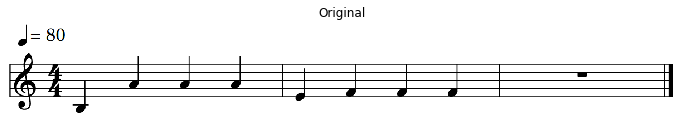

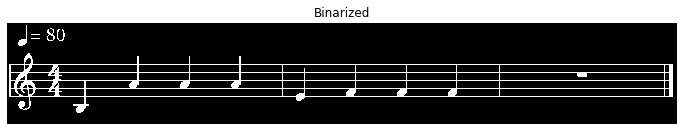

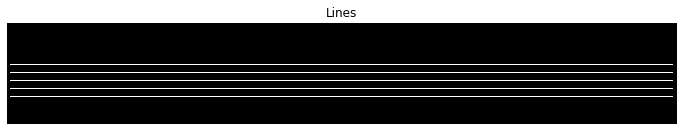

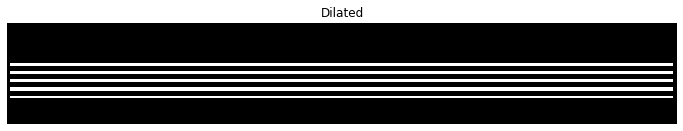

In [22]:
filename = "../assets/songtron_test_0.png"
pic = imageio.imread(filename)
gray = lambda rgb : np.dot(rgb[... , :3] , [0.21 , 0.72, 0.07])

plt.figure(figsize=(12,12))
plt.title("Original")
plt.imshow(pic, cmap='gray')
plt.axis('off')

bin_img = threshold(gray(pic), otsu_threshold(pic))
plt.figure(figsize=(12,12))
plt.title("Binarized")
plt.imshow(bin_img, cmap='gray')
plt.axis('off')

lines = kernel_horizontal(bin_img)
plt.figure(figsize=(12,12))
plt.title("Lines")
plt.imshow(lines, cmap='gray')
plt.axis('off')

#Morphological closing.
lines_kernel = np.ones((4,1),np.uint8)
dilated_lines = cv2.dilate(lines, lines_kernel, iterations=1)

plt.figure(figsize=(12,12))
plt.title("Dilated")
plt.imshow(dilated_lines, cmap='gray')
plt.axis('off')

#Here it would be nice if we segmented the lines.
"""segmented_lines = do_segmentation(lines, otsu_threshold(pic))

plt.figure(figsize=(20,20))
plt.title("Segmented")
plt.imshow(segmented_lines, cmap='magma')
plt.axis('off')
"""

lines_h = find_lines_height(dilated_lines,otsu_threshold(pic))
lines_h